# Aim

Build and analyze a Kalman filter on real SEAL data, in particular to notch out the natural frequency at 17 Hz.

In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import numpy as np
from scipy.signal import welch, windows
from scipy.stats import normaltest, chi2
from scipy.stats import multivariate_normal as mvn
from matplotlib import pyplot as plt
%matplotlib inline

In [147]:
import sys
sys.path.append("..")
from src.utils import genpsd
from src.controllers import SystemIdentifier
from src.controllers import design_filt, filt, design_from_ol
rms = lambda data: round(np.sqrt(np.mean((data - np.mean(data)) ** 2)), 4)

In [148]:
ol = np.load("../data/tt_center_noise/tt_center_noise_nsteps_10000_delay_0.01_dt_21_07_2021_12.npy")

In [424]:
ident = SystemIdentifier(ol[:2000], fs=100, N_vib_max=1)
params, variances, _ = ident.vibe_fit_freq(0)
klv = ident.make_klqg_vibe(params, variances * 5e10) # reset variances somehow
params, variances, _ = ident.vibe_fit_freq(1)
klv = klv.concat(ident.make_klqg_vibe(params, variances * 5e10))
klv.V = 1e-2 * np.eye(klv.measure_size)
klv.recompute()
process_dist = mvn(cov=klv.W, allow_singular=True)
measure_dist = mvn(cov=klv.V, allow_singular=True)

Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.


In [425]:
measurements = ol[2000:] + np.random.normal(0, 0.01, (8000,2))
states_v = klv.filter(measurements, np.zeros(klv.state_size,))

In [426]:
rms(measurements)

0.0109

In [427]:
res2 = ol[2000:] - states_v @ klv.C.T

In [428]:
rms(res2)

0.0057

In [429]:
f, p = genpsd(ol[:8000,0], dt=0.01)
fres2, pres2 = genpsd(res2[:,0], dt=0.01)

Text(0.5, 1.0, 'Controller design to reject the natural vibration spike on FAST')

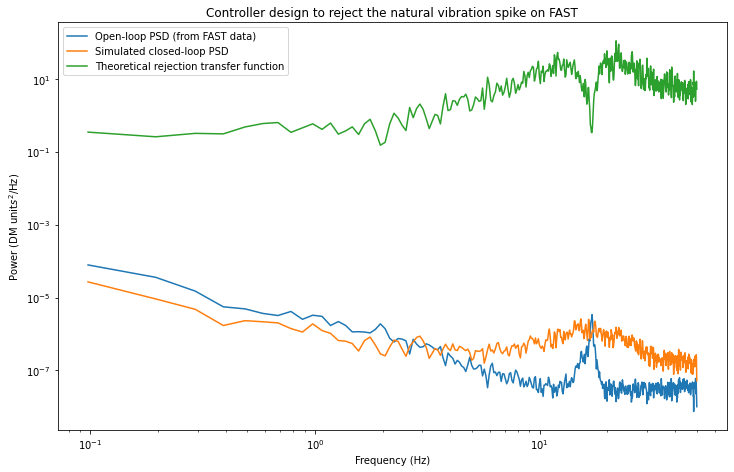

In [430]:
plt.figure(figsize=(12,7.5))
plt.loglog(f, p, label="Open-loop PSD (from FAST data)")
plt.loglog(fres2, pres2, label="Simulated closed-loop PSD")
plt.loglog(fres2, pres2/p, label="Theoretical rejection transfer function")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Power (DM unit$s^2$/Hz)")
plt.title("Controller design to reject the natural vibration spike on FAST")
# plt.savefig("../plots/rtf_vibe.png")

In [432]:
nsteps = 10000
states_un = np.zeros((nsteps, klv.state_size))
states_un[0,:] = process_dist.rvs()
for i in range(1, nsteps):
    states_un[i,:] = klv.A @ states_un[i-1,:] + process_dist.rvs()
    
rms(states_un @ klv.C.T)

0.1328

In [434]:
fun, pun = genpsd((states_un @ klv.C.T)[:,0], dt=0.01)
fol, pol = genpsd(ol[:,0], dt=0.01)

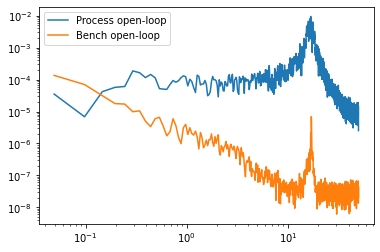

In [435]:
plt.loglog(fun, pun, label="Process open-loop")
plt.loglog(fol, pol, label="Bench open-loop")
plt.legend()

In [327]:
states = np.zeros((nsteps, klv.state_size))
states[0,:] = x
klv.x = x
for i in range(1, nsteps):
    u = klv.control()
    klv.predict(u)
    x = klv.A @ states[i-1,:] + klv.B @ u + process_dist.rvs()
    y = klv.C @ x + measure_dist.rvs()
    klv.update(y)
    states[i,:] = x
    
rms(states @ klv.C.T)

0.0001

In [328]:
f, p = genpsd((states_un @ klv.C.T)[:,0])
fres2, pres2 = genpsd((states @ klv.C.T)[:,0])

Text(0.5, 1.0, 'Controller design to reject the natural vibration spike on FAST')

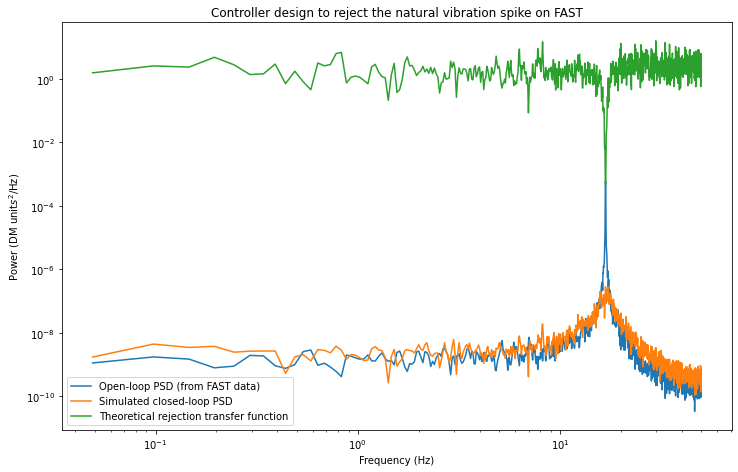

In [287]:
plt.figure(figsize=(12,7.5))
plt.loglog(f, p, label="Open-loop PSD (from FAST data)")
plt.loglog(fres2, pres2, label="Simulated closed-loop PSD")
plt.loglog(fres2, pres2/p, label="Theoretical rejection transfer function")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Power (DM unit$s^2$/Hz)")
plt.title("Controller design to reject the natural vibration spike on FAST")

In [248]:
rms(states_un @ klv.C.T)

12.4047